In [1]:
import numpy as np
import h5py
import time
import json
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
x_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_x.h5"
y_train_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_train_y.h5"

x_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_x.h5"
y_valid_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_valid_y.h5"

x_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_x.h5"
y_test_path = "/kaggle/input/pcam-dataset/camelyonpatch_level_2_split_test_y.h5"

In [3]:
class PCamDataset(Dataset):
    def __init__(self, x_path, y_path, transform):
        self.transform = transform

        with h5py.File(x_path, "r") as file_x, h5py.File(y_path, "r") as file_y:
            self.images = file_x["x"][:]
            self.labels = file_y["y"][:]

        self.length = len(self.images)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32).squeeze()

        return img, label

In [4]:
def compute_metrics(labels, preds, probs):
    labels = np.array(labels)
    preds = np.array(preds)
    probs = np.array(probs)

    accuracy = 100 * accuracy_score(labels, preds)

    if np.sum(preds) == 0:
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    else:
        precision = precision_score(labels, preds, average="binary")
        recall = recall_score(labels, preds, average="binary")
        f1 = f1_score(labels, preds, average="binary")

    if np.sum(labels) == 0 or np.sum(preds) == 0:
        roc_auc = 0.0
        pr_auc = 0.0
    else:
        roc_auc = roc_auc_score(labels, probs)
        pr_auc = average_precision_score(labels, probs)

    return {
        "accuracies": accuracy,
        "precisions": precision,
        "recalls": recall,
        "f1s": f1,
        "rocs": roc_auc,
        "prs": pr_auc,
    }


def round_metrics(metrics, decimals=4):
    def round_value(value):
        if isinstance(value, float):
            return round(value, decimals)
        elif isinstance(value, list):
            return [round_value(v) for v in value]
        elif isinstance(value, tuple):
            return tuple(round_value(v) for v in value)
        elif isinstance(value, dict):
            return {k: round_value(v) for k, v in value.items()}
        return value

    return {key: round_value(values) for key, values in metrics.items()}

In [5]:
def plot_metrics(epochs_range, train_vals, val_vals, ylabel, title):
    plt.plot(epochs_range, train_vals, label="Train")
    plt.plot(epochs_range, val_vals, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()

In [6]:
def test_model(model, test_loader):
    running_test_loss = 0.0
    test_preds, test_labels, test_probs = [], [], []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.detach().cpu().numpy())

    running_test_loss /= len(test_loader)
    test_metrics = compute_metrics(test_labels, test_preds, test_probs)

    print(
        f"Test Loss: {running_test_loss:.4f}, "
        f"Acc: {test_metrics['accuracies']:.4f}%, "
        f"F1: {test_metrics['f1s']:.4f}\n"
    )

    return test_metrics

In [7]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
):
    metrics = {
        "losses": ([], []),
        "accuracies": ([], []),
        "precisions": ([], []),
        "recalls": ([], []),
        "f1s": ([], []),
        "rocs": ([], []),
        "prs": ([], []),
    }

    test_metrics = {}
    best_test_accuracy = 0.0

    total_train_time, total_val_time = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        start_time = time.time()
        running_train_loss = 0.0
        train_preds, train_labels, train_probs = [], [], []

        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(dim=1)
            loss = criterion(outputs, labels)
            loss.backward()    
            optimizer.step()

            running_train_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs.detach().cpu().numpy())

        total_train_time += time.time() - start_time
        train_metrics = compute_metrics(train_labels, train_preds, train_probs)

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            start_time = time.time()
            running_val_loss = 0.0
            val_preds, val_labels, val_probs = [], [], []

            for images, labels in tqdm(
                val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False
            ):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).long()

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

            total_val_time += time.time() - start_time
            val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        running_train_loss /= len(train_loader)
        running_val_loss /= len(val_loader)

        metrics["losses"][0].append(running_train_loss)
        metrics["losses"][1].append(running_val_loss)

        for key in metrics.keys():
            if key != "losses":
                metrics[key][0].append(train_metrics[key])
                metrics[key][1].append(val_metrics[key])

        print(
            f"Epoch [{epoch}/{epochs}]:\n"
            f"Train Loss: {metrics['losses'][0][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][0][-1]:.4f}%, "
            f"F1: {metrics['f1s'][0][-1]:.4f}\n"
            f"Val Loss: {metrics['losses'][1][-1]:.4f}, "
            f"Acc: {metrics['accuracies'][1][-1]:.4f}%, "
            f"F1: {metrics['f1s'][1][-1]:.4f}\n"
        )

        if epoch == 10 or epoch == 15 or epoch == 25:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_{epoch}.pth")

        test_met = test_model(model, test_loader)
        test_metrics[f"Testing_{epoch}"] = test_met

        test_accuracy = test_met["accuracies"]

        if epoch == 10 or epoch == 15 or epoch == 25:
            print(f"Test Accuracy at epoch: {epoch} is {test_accuracy} %\n")
            
        if test_accuracy >= best_test_accuracy:
            best_test_accuracy = test_accuracy
            print(f"Best Model saving at epoch: {epoch} with accuracy: {test_accuracy} %\n")
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": (
                    scheduler.state_dict() if scheduler is not None else None
                ),
            }
            torch.save(checkpoint, f"model_best.pth")

    total_train_time /= 60
    total_val_time /= 60

    print(
        f"Total Training Time: {(total_train_time):.2f} min, Validation Time: {(total_val_time):.2f} min"
    )

    metrics["total_times"] = {
        "training_time (mins)": total_train_time,
        "validation_time (mins)": total_val_time,
    }
    metrics["Testing"] = test_metrics

    return metrics

In [8]:
train_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.Resize((96, 96)),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = PCamDataset(x_train_path, y_train_path, transform=train_transform)
val_dataset = PCamDataset(x_valid_path, y_valid_path, transform=test_transform)
test_dataset = PCamDataset(x_test_path, y_test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [9]:
model = models.vgg13(weights=models.VGG13_Weights.DEFAULT)

features = list(model.features)
modified_features = []

i = 0
while i < len(features):
    layer = features[i]
    modified_features.append(layer)
    
    if isinstance(layer, nn.Conv2d):
        if i + 1 < len(features) and not isinstance(features[i + 1], nn.BatchNorm2d):
            modified_features.append(nn.BatchNorm2d(layer.out_channels))
    
    if isinstance(layer, nn.MaxPool2d) and i > 6:
        dropout_prob = 0.2 if i < 20 else 0.3
        modified_features.append(nn.Dropout2d(dropout_prob))
    
    i += 1

model.features = nn.Sequential(*modified_features)
        
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 1)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0001)

epochs = 40

print(model)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:02<00:00, 212MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.2

Epoch [1/40]:
Train Loss: 0.5027, Acc: 76.1715%, F1: 0.7721
Val Loss: 0.4588, Acc: 78.0945%, F1: 0.7981



Test Loss: 0.4817, Acc: 77.2278%, F1: 0.7851

Best Model saving at epoch: 1 with accuracy: 77.227783203125 %



Epoch [2/40]:
Train Loss: 0.4368, Acc: 80.3627%, F1: 0.8072
Val Loss: 0.4446, Acc: 79.1504%, F1: 0.8045



Test Loss: 0.4683, Acc: 77.7893%, F1: 0.7850

Best Model saving at epoch: 2 with accuracy: 77.789306640625 %



Epoch [3/40]:
Train Loss: 0.3906, Acc: 82.8369%, F1: 0.8293
Val Loss: 0.3897, Acc: 82.0709%, F1: 0.8297



Test Loss: 0.4218, Acc: 80.7373%, F1: 0.8113

Best Model saving at epoch: 3 with accuracy: 80.7373046875 %



Epoch [4/40]:
Train Loss: 0.3557, Acc: 84.5745%, F1: 0.8451
Val Loss: 0.3556, Acc: 83.4595%, F1: 0.8372



Test Loss: 0.3673, Acc: 83.3618%, F1: 0.8342

Best Model saving at epoch: 4 with accuracy: 83.36181640625 %



Epoch [5/40]:
Train Loss: 0.3257, Acc: 86.0703%, F1: 0.8597
Val Loss: 0.3348, Acc: 84.7565%, F1: 0.8510



Test Loss: 0.3464, Acc: 84.9609%, F1: 0.8516

Best Model saving at epoch: 5 with accuracy: 84.9609375 %



Epoch [6/40]:
Train Loss: 0.3070, Acc: 87.1147%, F1: 0.8700
Val Loss: 0.3372, Acc: 84.6802%, F1: 0.8492



Test Loss: 0.3487, Acc: 84.5184%, F1: 0.8447



Epoch [7/40]:
Train Loss: 0.2916, Acc: 87.9070%, F1: 0.8777
Val Loss: 0.3291, Acc: 85.1685%, F1: 0.8555



Test Loss: 0.3413, Acc: 84.7809%, F1: 0.8482



Epoch [8/40]:
Train Loss: 0.2800, Acc: 88.4159%, F1: 0.8827
Val Loss: 0.3145, Acc: 85.9650%, F1: 0.8607



Test Loss: 0.3031, Acc: 87.1735%, F1: 0.8728

Best Model saving at epoch: 8 with accuracy: 87.1734619140625 %



Epoch [9/40]:
Train Loss: 0.2702, Acc: 88.9145%, F1: 0.8877
Val Loss: 0.3278, Acc: 85.2539%, F1: 0.8518



Test Loss: 0.3180, Acc: 86.0535%, F1: 0.8589



Epoch [10/40]:
Train Loss: 0.2625, Acc: 89.3219%, F1: 0.8918
Val Loss: 0.3095, Acc: 86.0016%, F1: 0.8670



Test Loss: 0.2983, Acc: 87.2253%, F1: 0.8767

Test Accuracy at epoch: 10 is 87.225341796875 %

Best Model saving at epoch: 10 with accuracy: 87.225341796875 %



Epoch [11/40]:
Train Loss: 0.2550, Acc: 89.6900%, F1: 0.8955
Val Loss: 0.3005, Acc: 87.0728%, F1: 0.8680



Test Loss: 0.2986, Acc: 87.4481%, F1: 0.8700

Best Model saving at epoch: 11 with accuracy: 87.4481201171875 %



Epoch [12/40]:
Train Loss: 0.2490, Acc: 89.9162%, F1: 0.8978
Val Loss: 0.3003, Acc: 87.1643%, F1: 0.8681



Test Loss: 0.2861, Acc: 87.6953%, F1: 0.8720

Best Model saving at epoch: 12 with accuracy: 87.6953125 %



Epoch [13/40]:
Train Loss: 0.2448, Acc: 90.1699%, F1: 0.9003
Val Loss: 0.2878, Acc: 87.8174%, F1: 0.8767



Test Loss: 0.2692, Acc: 88.7756%, F1: 0.8859

Best Model saving at epoch: 13 with accuracy: 88.775634765625 %



Epoch [14/40]:
Train Loss: 0.2372, Acc: 90.5602%, F1: 0.9044
Val Loss: 0.3118, Acc: 86.6547%, F1: 0.8591



Test Loss: 0.3065, Acc: 86.4044%, F1: 0.8541



Epoch [15/40]:
Train Loss: 0.2319, Acc: 90.7673%, F1: 0.9064
Val Loss: 0.2878, Acc: 87.7655%, F1: 0.8784



Test Loss: 0.2915, Acc: 87.7472%, F1: 0.8759

Test Accuracy at epoch: 15 is 87.7471923828125 %



Epoch [16/40]:
Train Loss: 0.2288, Acc: 90.9348%, F1: 0.9082
Val Loss: 0.3158, Acc: 87.0117%, F1: 0.8633



Test Loss: 0.2921, Acc: 87.3322%, F1: 0.8656



Epoch [17/40]:
Train Loss: 0.2251, Acc: 91.1366%, F1: 0.9103
Val Loss: 0.2902, Acc: 88.0463%, F1: 0.8774



Test Loss: 0.2900, Acc: 87.5824%, F1: 0.8704



Epoch [18/40]:
Train Loss: 0.2211, Acc: 91.3280%, F1: 0.9122
Val Loss: 0.3020, Acc: 87.7106%, F1: 0.8712



Test Loss: 0.2943, Acc: 87.4542%, F1: 0.8663



Epoch [19/40]:
Train Loss: 0.2174, Acc: 91.4581%, F1: 0.9134
Val Loss: 0.2853, Acc: 88.5620%, F1: 0.8817



Test Loss: 0.2776, Acc: 88.3453%, F1: 0.8777



Epoch [20/40]:
Train Loss: 0.2128, Acc: 91.6759%, F1: 0.9157
Val Loss: 0.2769, Acc: 88.8733%, F1: 0.8851



Test Loss: 0.2505, Acc: 89.4440%, F1: 0.8905

Best Model saving at epoch: 20 with accuracy: 89.4439697265625 %



Epoch [21/40]:
Train Loss: 0.2109, Acc: 91.7305%, F1: 0.9162
Val Loss: 0.2762, Acc: 88.7146%, F1: 0.8843



Test Loss: 0.2604, Acc: 89.2456%, F1: 0.8889



Epoch [22/40]:
Train Loss: 0.2078, Acc: 91.9106%, F1: 0.9180
Val Loss: 0.3107, Acc: 87.5214%, F1: 0.8675



Test Loss: 0.3088, Acc: 86.7035%, F1: 0.8560



Epoch [23/40]:
Train Loss: 0.2061, Acc: 91.9621%, F1: 0.9187
Val Loss: 0.2786, Acc: 88.8275%, F1: 0.8842



Test Loss: 0.2807, Acc: 87.9883%, F1: 0.8730



Epoch [24/40]:
Train Loss: 0.2043, Acc: 92.0883%, F1: 0.9199
Val Loss: 0.2765, Acc: 88.7695%, F1: 0.8834



Test Loss: 0.2635, Acc: 88.7177%, F1: 0.8813



Epoch [25/40]:
Train Loss: 0.2003, Acc: 92.2123%, F1: 0.9211
Val Loss: 0.2899, Acc: 88.4308%, F1: 0.8791



Test Loss: 0.2726, Acc: 88.2660%, F1: 0.8757

Test Accuracy at epoch: 25 is 88.2659912109375 %



Epoch [26/40]:
Train Loss: 0.1985, Acc: 92.2981%, F1: 0.9220
Val Loss: 0.2862, Acc: 88.6993%, F1: 0.8797



Test Loss: 0.2939, Acc: 87.2711%, F1: 0.8612



Epoch [27/40]:
Train Loss: 0.1965, Acc: 92.4099%, F1: 0.9232
Val Loss: 0.2837, Acc: 88.5406%, F1: 0.8810



Test Loss: 0.2619, Acc: 88.8153%, F1: 0.8826



Epoch [28/40]:
Train Loss: 0.1954, Acc: 92.4610%, F1: 0.9237
Val Loss: 0.2701, Acc: 88.9832%, F1: 0.8876



Test Loss: 0.2555, Acc: 89.3127%, F1: 0.8896



Epoch [29/40]:
Train Loss: 0.1941, Acc: 92.5312%, F1: 0.9244
Val Loss: 0.2866, Acc: 88.5498%, F1: 0.8798



Test Loss: 0.2838, Acc: 87.7808%, F1: 0.8693



Epoch [30/40]:
Train Loss: 0.1911, Acc: 92.5896%, F1: 0.9250
Val Loss: 0.2936, Acc: 88.3789%, F1: 0.8788



Test Loss: 0.2699, Acc: 88.3667%, F1: 0.8777



Epoch [31/40]:
Train Loss: 0.1902, Acc: 92.7055%, F1: 0.9262
Val Loss: 0.2919, Acc: 88.2751%, F1: 0.8752



Test Loss: 0.2860, Acc: 87.2986%, F1: 0.8618



Epoch [32/40]:
Train Loss: 0.1889, Acc: 92.7284%, F1: 0.9264
Val Loss: 0.2835, Acc: 88.6597%, F1: 0.8804



Test Loss: 0.2665, Acc: 88.3240%, F1: 0.8752



Epoch [33/40]:
Train Loss: 0.1863, Acc: 92.8684%, F1: 0.9278
Val Loss: 0.2741, Acc: 88.8580%, F1: 0.8828



Test Loss: 0.2754, Acc: 88.1195%, F1: 0.8726



Epoch [34/40]:
Train Loss: 0.1852, Acc: 92.9199%, F1: 0.9284
Val Loss: 0.2948, Acc: 88.1775%, F1: 0.8750



Test Loss: 0.2813, Acc: 88.0585%, F1: 0.8723



Epoch [35/40]:
Train Loss: 0.1841, Acc: 92.9367%, F1: 0.9285
Val Loss: 0.2963, Acc: 88.3575%, F1: 0.8760



Test Loss: 0.2808, Acc: 87.9547%, F1: 0.8699



Epoch [36/40]:
Train Loss: 0.1842, Acc: 92.9520%, F1: 0.9287
Val Loss: 0.2707, Acc: 89.3707%, F1: 0.8886



Test Loss: 0.2626, Acc: 89.0442%, F1: 0.8835



Epoch [37/40]:
Train Loss: 0.1822, Acc: 93.0637%, F1: 0.9298
Val Loss: 0.2841, Acc: 89.1602%, F1: 0.8852



Test Loss: 0.2725, Acc: 88.6566%, F1: 0.8781



Epoch [38/40]:
Train Loss: 0.1808, Acc: 93.1282%, F1: 0.9305
Val Loss: 0.2719, Acc: 89.3036%, F1: 0.8893



Test Loss: 0.2650, Acc: 88.8794%, F1: 0.8831



Epoch [39/40]:
Train Loss: 0.1796, Acc: 93.1595%, F1: 0.9308
Val Loss: 0.2989, Acc: 88.4369%, F1: 0.8779



Test Loss: 0.2885, Acc: 87.6953%, F1: 0.8672



Epoch [40/40]:
Train Loss: 0.1788, Acc: 93.2152%, F1: 0.9313
Val Loss: 0.2876, Acc: 88.6322%, F1: 0.8803



Test Loss: 0.2811, Acc: 88.1226%, F1: 0.8730

Total Training Time: 337.49 min, Validation Time: 12.73 min


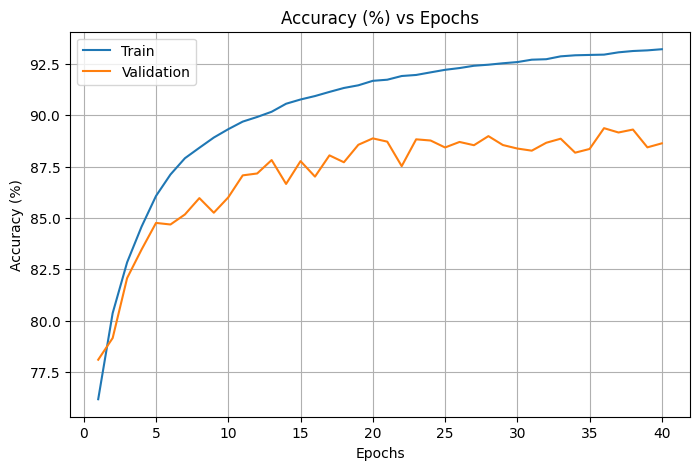

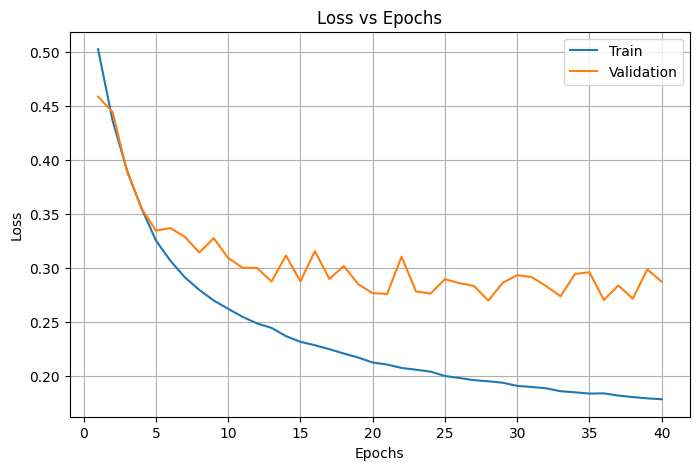

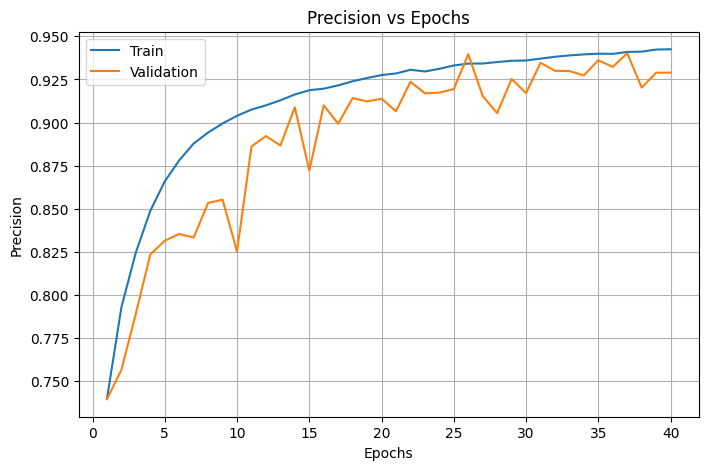

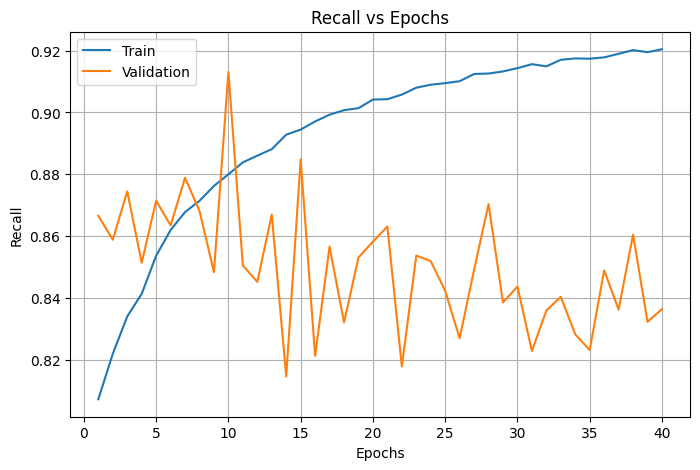

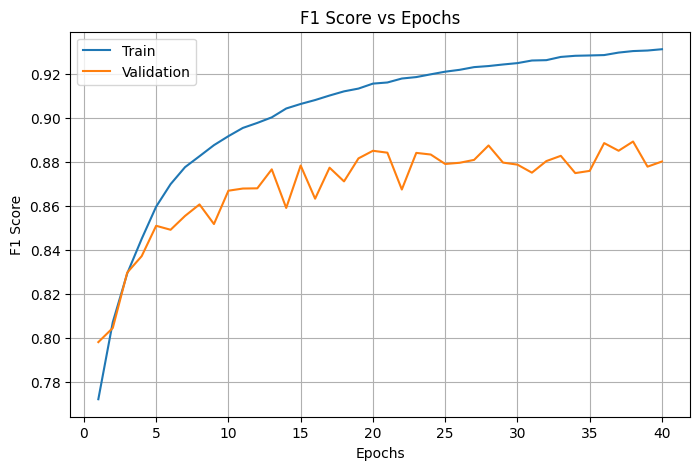

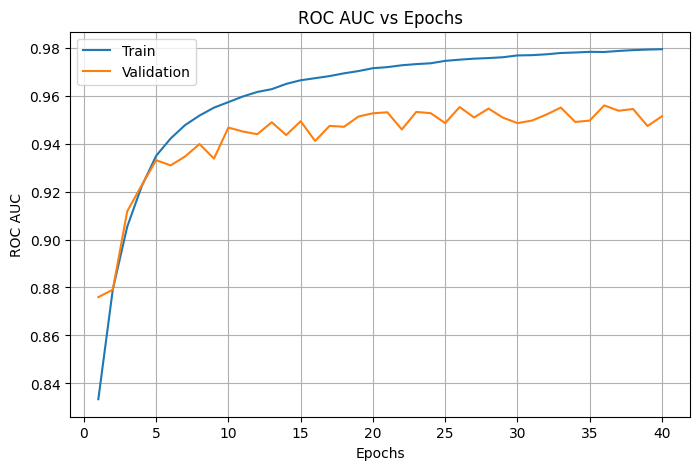

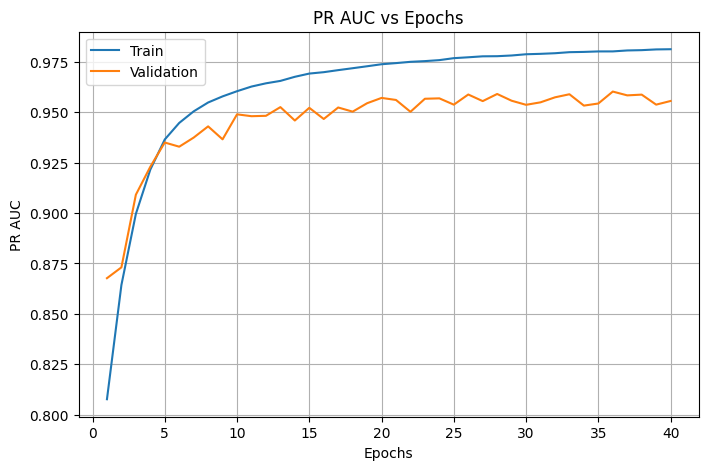

In [10]:
train_metrics = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs
)

with open("metrics.json", "w") as f:
    json.dump(round_metrics(train_metrics), f, indent=4)

epochs_range = range(1, epochs + 1)

metric_names = [
    "accuracies",
    "losses",
    "precisions",
    "recalls",
    "f1s",
    "rocs",
    "prs",
]
metric_labels = [
    "Accuracy (%)",
    "Loss",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC AUC",
    "PR AUC",
]

for metric, label in zip(metric_names, metric_labels):
    plt.figure(figsize=(8, 5))
    plot_metrics(epochs_range, *train_metrics[metric], label, f"{label} vs Epochs")
    plt.savefig(f"{metric}.png", bbox_inches="tight")
    plt.show()
    plt.close()